In [83]:
from aspen_api import aspen
from make_csv import make_csv
from sampling import grid_sample, latin_hypercube_sample
from nn_loader import loader
from nn_utils import load_checkpoint, save_checkpoint

In [85]:
bounds = {"x1":[-10, 10], "x2":[-10, 10]}
# # X_sample = latin_hypercube_sample(bounds, num_samples=10000, seed=42)
X_sample = grid_sample(bounds, num_samples=10000)

In [86]:
file_name="002_recreate.bkp"
sim = aspen(path=file_name)

x, y = sim.sampling(X_sample)

In [87]:
print(len(x))
print(len(x[0]))

10000
2


In [88]:
print(len(y))
print(len(y[0]))

10000
2


In [89]:
columns_lab = ["x1", "x2", "y1", "y2"]
make_csv(x, y, column_lab=columns_lab, file_name="data.csv")

Saving the data == DATA/data.csv


In [90]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
dataset = loader(csv_file="DATA/data.csv")

In [91]:
from nn_surrogate import NN_surrogate

model = NN_surrogate(input_size=2, output_size=2)
model.to(device)

NN_surrogate(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)

In [92]:
def train_(model, loader, criterion, optimizer):
    for batch_idx, (data, targets) in enumerate(loader):
#         print(data.shape)
#         print(targets.shape)
        data = data.to(device=device)
        targets = targets.to(device=device)

        pred = model(data.float())
        loss = criterion(pred, targets.float())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    return loss

In [93]:
generator1 = torch.Generator().manual_seed(42)

In [94]:
from torch.utils.data import DataLoader 

batch_size = 16

proportions = [.75, .25]
lengths = [int(p * len(dataset)) for p in proportions]
lengths[-1] = len(dataset) - sum(lengths[:-1])
train_set, test_set = torch.utils.data.random_split(dataset, lengths, generator=generator1)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


In [95]:
import torch.nn as nn
import torch.optim as optim

learning_rate = 0.003
num_epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses=[]
for epoch in range(num_epochs):
    loss = train_(model=model, loader=train_loader, criterion=criterion, optimizer=optimizer)
    losses.append(loss.detach().numpy().item())

In [96]:
print(losses)

[2427767.75, 2645080.0, 6083284.0, 6069044.0, 8377226.5, 543989.625, 4496405.5, 3354137.0, 870262.5, 2961538.25, 7778416.0, 3499373.25, 3364273.0, 3134828.75, 786399.25, 1556958.125, 634408.0625, 1852531.375, 2777843.75, 6040645.5, 952466.75, 2364711.75, 2920743.0, 720091.1875, 3095403.0, 838942.75, 1454430.875, 1609957.5, 406073.59375, 459248.65625, 1802019.625, 5070892.5, 2312169.0, 1464266.875, 2031080.125, 232357.328125, 1069234.75, 1978906.875, 141751.421875, 2599035.75, 1308457.875, 2551247.75, 584464.125, 1628177.875, 2661414.25, 365832.34375, 1704066.125, 1615081.5, 2338519.5, 1385321.875, 1830746.0, 1652090.875, 2974237.75, 2454257.75, 1017647.5, 424273.71875, 3276203.75, 5842428.5, 2333229.75, 172982.890625, 399477.71875, 1141630.75, 859110.9375, 889729.5625, 1518583.0, 850452.75, 2090074.0, 568015.6875, 355879.90625, 2179903.25, 434666.21875, 258737.109375, 495052.53125, 2736209.25, 1830745.875, 3397524.75, 1075492.125, 1568509.125, 2657155.5, 335216.34375, 1654151.125, 1535

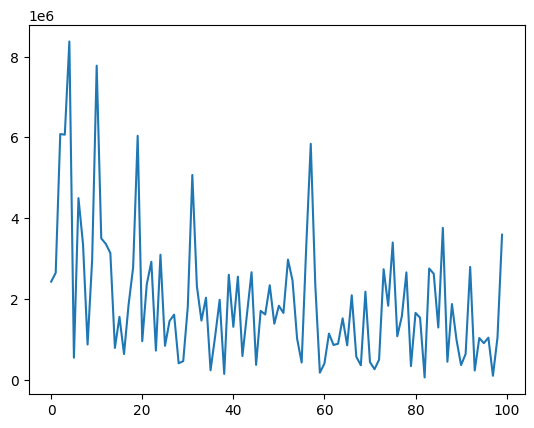

In [97]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [98]:
checkpoint = {'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
save_checkpoint(checkpoint)

__Saving Checkpoint__


In [99]:
model_load = NN_surrogate(input_size=2, output_size=2)
model_load.to(device)

NN_surrogate(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)

In [100]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(model=model_load, optimizer=optimizer, checkpoint=torch.load("MODEL/nn_surrogate.pth.tar", map_location=device))

__Loading Checkpoint__


In [101]:
model_load(torch.tensor([3.2,4.3]))

tensor([-124.2898,   -2.1996], grad_fn=<AddBackward0>)

In [102]:
model(torch.tensor([3.2, 4.3]))

tensor([-124.2898,   -2.1996], grad_fn=<AddBackward0>)

In [103]:
def func(x):
#         y1 = np.sqrt(np.absolute(np.sin(np.sqrt(np.absolute(x[0]**2+x[1]**2)))))+0.01*(x[0]+x[1])
        y1 = -x[0]*x[1]*(72-2*x[0]-2*x[1]) 
        y2 = 2*x[0]+3*x[1]-2

        y = [y1, y2]

        return y


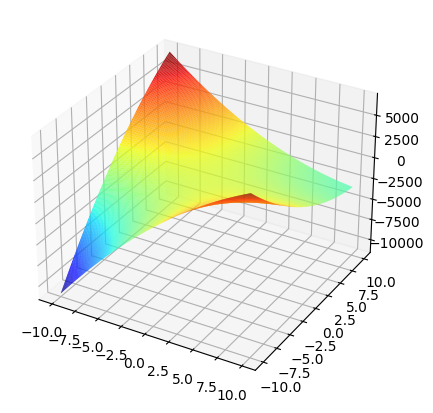

In [104]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X, Y = np.meshgrid(X,Y)
Z1 = np.zeros(X.shape)
Z2 = np.zeros(X.shape)

for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    Z1[i, j], Z2[i, j] = func([X[i, j], Y[i, j]])

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

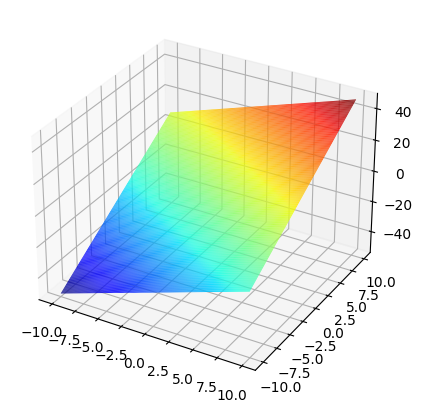

In [105]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

In [106]:
def preds(x):
    x = torch.tensor(x)
    x = x.type(torch.float32)
    y = model_load(x)
    return y

In [107]:
print(preds([1,1]))

tensor([-124.2898,   -2.1996], grad_fn=<AddBackward0>)


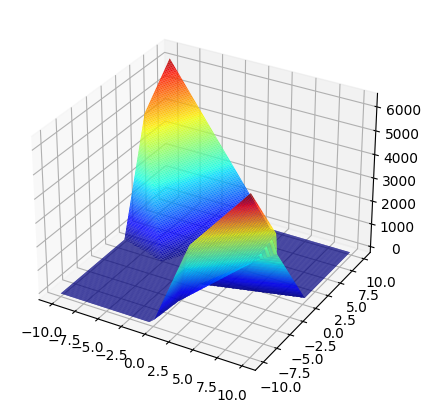

In [108]:
X = np.arange(-10,10,0.1)
Y = np.arange(-10,10,0.1)
X, Y = np.meshgrid(X,Y)
Z1 = np.zeros(X.shape)
Z2 = np.zeros(X.shape)

for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    Z1[i, j], Z2[i, j] = preds([X[i, j], Y[i, j]])

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

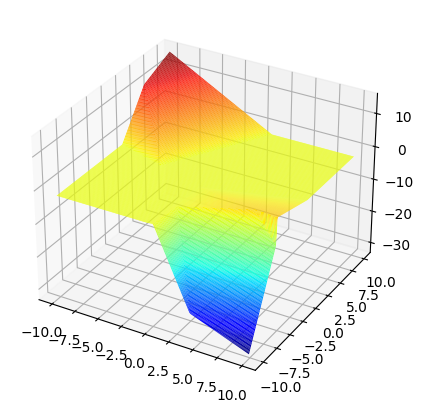

In [109]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

MOO

In [110]:
!pip install -U pymoo

In [111]:
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2

In [112]:
x=np.array([0.12362036, 1.85214292]) 
print(x)
x = x.tolist()
x = torch.tensor(x)
x = x.type(torch.float32)
y = model_load(x)
y = y.data
print(y)
y.cpu().detach().numpy()
a,b =y
a

[0.12362036 1.85214292]
tensor([-124.2898,   -2.1996])


tensor(-124.2898)

In [113]:
class ProblemWrapper(Problem):
    def _evaluate(self, designs, out, *args, **kwargs):
        res = []
        for design in designs:
            design_tensor = design.tolist()
            design_tensor = torch.tensor(design_tensor)
            design_tensor = design_tensor.type(torch.float32)
            f = model_load(design_tensor)
            f = f.data
            f.cpu().detach().numpy()
            f1, f2 = f
            tup = [f1, f2]
            res.append((f1, f2))
        out["F"]=np.array(res)

In [114]:
problem = ProblemWrapper(n_var=2, n_obj=2, xl=[-1,-1], xu=[2,2])

In [115]:
algorithm = NSGA2(pop_size=100)

In [116]:
stop_criteria = ('n_gen', 100)

In [117]:
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   seed=42,
                   save_history=True)

In [118]:
results.F

array([[-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   -2.19956589],
       [-124.2897644 ,   

In [119]:
results.X

array([[ 0.0678061 ,  0.20871163],
       [ 1.50907295, -0.92868962],
       [ 1.74700342,  1.46519137],
       [-0.82384575, -0.96713796],
       [-0.71894827,  1.07921378],
       [-0.4232799 ,  0.81781839],
       [-0.61898127,  0.82628657],
       [ 1.52372296,  1.48482922],
       [-0.96666767, -0.89460436],
       [ 1.03356813,  1.15354959],
       [ 1.40751353,  0.83921964],
       [ 1.0444785 ,  1.89722028],
       [ 1.85986182,  1.83919954],
       [ 0.49317561,  0.86462763],
       [-0.77530187,  0.84146496],
       [-0.90586811, -0.87101274],
       [-0.61500496,  1.08995348],
       [-0.34066606,  0.38757231],
       [-0.87030245, -0.98300113],
       [ 1.9713967 ,  0.81555205],
       [ 0.06649004,  0.79332324],
       [ 0.12127791,  1.91305109],
       [ 1.56710229,  0.80185949],
       [ 1.74525964,  0.56630832],
       [ 1.83048569,  0.34234324],
       [ 0.03126067,  0.33217089],
       [ 1.3197022 ,  0.20559635],
       [-0.25246981, -0.6713671 ],
       [-0.64740434,

In [120]:
len(results.history)

100

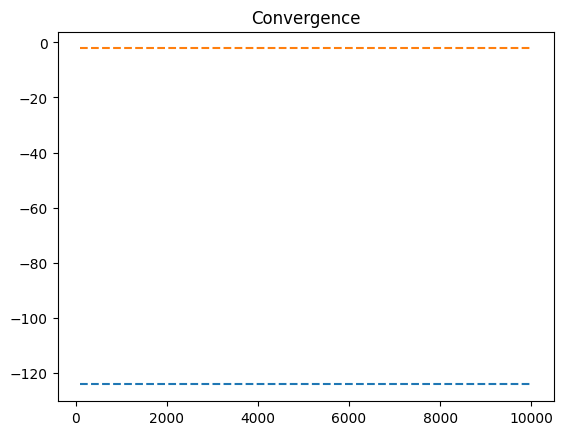

In [121]:
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
# plt.yscale("log")
plt.show()